In [5]:
import numpy as np
from tensorflow.keras import datasets
from tensorflow.keras import layers
from tensorflow.keras.backend import int_shape
from tensorflow.keras import models
import matplotlib.pyplot as plt
import random

In [6]:
def preprocess(images):
    images = images.astype('float32') / 255.0
    images = np.pad(images, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    images = np.expand_dims(images, -1)
    return images

In [7]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

x_train = preprocess(x_train)
x_test = preprocess(x_test)

## Build Encoder Network

In [8]:
encoder_input = layers.Input(
    shape=(32, 32, 1), name='encoder_input'
)

x = layers.Conv2D(32, (3, 3), strides=2, activation='relu', padding='same')(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)

shape_before_flattening = int_shape(x)[1:]

x = layers.Flatten()(x)
encoder_output = layers.Dense(2, name='encoder_output')(x)

encoder = models.Model(encoder_input, encoder_output)

2024-10-21 20:14:47.286510: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [9]:
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
Total params: 96,770
Trainable params: 96,770
Non-trainable p

## Build Decoder Network

In [10]:
decoder_input = layers.Input(
    shape=(2,), name='decoder_input'
)
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation='relu', padding='same'
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation='relu', padding='same'
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation='relu', padding='same'
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation='sigmoid',
    padding='same',
    name='decoder_output'
)(x)

decoder = models.Model(decoder_input, decoder_output)

In [11]:
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        147584    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 32)       1846

## Train model

In [12]:
autoencoder = models.Model(encoder_input, decoder(encoder_output))

In [13]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [14]:
autoencoder.fit(
    x_train,
    x_train,
    epochs=5,
    batch_size=100,
    shuffle=True,
    validation_data=(x_test, x_test)
)

Epoch 1/5
600/600 [==============================] - 279s 462ms/step - loss: 0.2922 - val_loss: 0.2600
Epoch 2/5
600/600 [==============================] - 276s 460ms/step - loss: 0.2559 - val_loss: 0.2553
Epoch 3/5
600/600 [==============================] - 317s 529ms/step - loss: 0.2526 - val_loss: 0.2531
Epoch 4/5
600/600 [==============================] - 320s 533ms/step - loss: 0.2509 - val_loss: 0.2525
Epoch 5/5
600/600 [==============================] - 319s 532ms/step - loss: 0.2498 - val_loss: 0.2512


## Explore results

In [16]:
x_test.shape

(10000, 32, 32, 1)

In [17]:
x_test_encoded = encoder.predict(x_test)

313/313 [==============================] - 3s 11ms/step


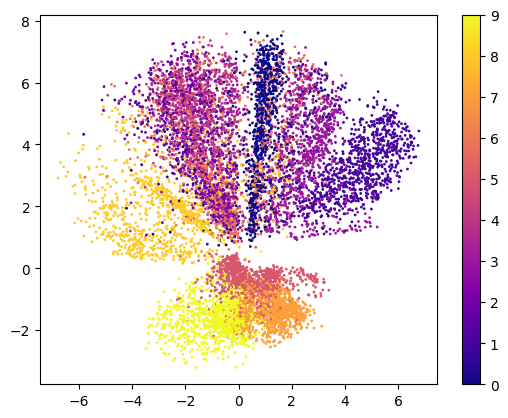

In [18]:
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, s=1, cmap='plasma')
plt.colorbar()

### Images and their reconstructions

1/1 [==============================] - 0s 34ms/step


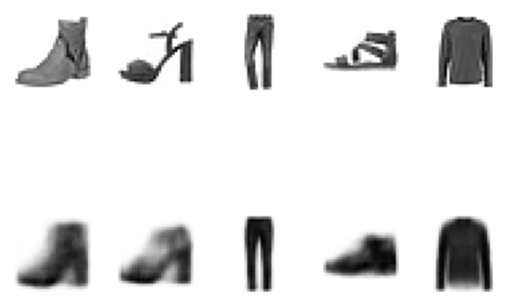

In [31]:
num_elems = 5

fig, axs = plt.subplots(2, num_elems)

for c in range(num_elems):
    img_idx = random.randint(0, x_test.shape[0]-1)

    real_img = x_test[[img_idx], :].reshape((32, 32))
    reconstructed_img = autoencoder.predict(real_img.reshape((1, 32, 32, 1))).reshape((32, 32))

    plt.sca(axs[0, c])

    plt.imshow(real_img, cmap='binary')
    plt.axis('off')

    plt.sca(axs[1, c])

    plt.imshow(reconstructed_img, cmap='binary')
    plt.axis('off')




### Generate new samples

In [42]:
max_x, max_y = np.max(x_test_encoded, axis=0)
min_x, min_y = np.min(x_test_encoded, axis=0)

1/1 [==============================] - 0s 38ms/step


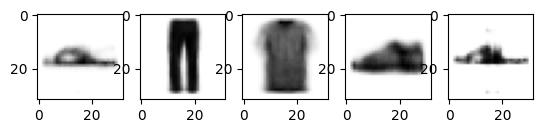

In [55]:
num_elems = 5

fig, axs = plt.subplots(1, num_elems)

for i in range(num_elems):
    x_pos, y_pos = random.uniform(min_x, max_x), random.uniform(min_y, max_y)
    gen_img = decoder.predict(np.array([x_pos, y_pos]).reshape((1, -1)))
    gen_img = gen_img.reshape((32, 32))
    plt.sca(axs[i])
    plt.imshow(gen_img, cmap='binary')

plt.show()